### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
    dfsss[cohort_n] = dataset

### Read harmonized mapping tables

In [4]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [5]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [6]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [7]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [8]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [9]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [10]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [11]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Read the subtables of all cohorts to extract the "age" feature and add it to the complete tables 

In [12]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [13]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [14]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [15]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read cutoff tables to plot the biomarkers based on each method

In [16]:
cut = [pd.read_csv(file, index_col=0) for file in sorted(glob.glob('../results/cutoffs' + "/*."+'csv'))]
method = [file.split(".")[0] for file in sorted(os.listdir('../results/cutoffs/'))]

In [17]:
# make a dictionary that contains all modalities as a dataframe
cutoffs_dfs = dict()

for values, method_name in zip(cut, method):
    cutoffs_dfs[method_name] = values

In [18]:
cutoffs_dfs['km_cutoffs'].rename(columns={col: col.split("_")[0] for col in cutoffs_dfs['km_cutoffs'].columns}, inplace=True)

### Exclude patients without CSF measurements for all cohorts

In [19]:
for i in cutoffs_dfs['gmm_cutoffs'].index.to_list():
    csfs = mappings['csf'].loc[mappings['csf'].iloc[:3].index, i].to_list()
    cohort_studies[i] = cohort_studies[i].dropna(subset=csfs)

In [20]:
for metho in set(cutoffs_dfs.keys()).difference(['cutoffs_cohort_study', 'gmm_baseline_cutoffs']):
    
    for study in cutoffs_dfs[metho].index:
        
        for bio in cutoffs_dfs[metho].columns:
            
            if bio.split("_")[0] == 'A-beta 1-42 in CSF':
                cut_it = cutoffs_dfs[metho].loc[study, bio.split("_")[0]].item()
                feature_name = mappings['csf'].loc[mappings['csf']['Feature']==bio.split("_")[0], study].item()
                new_col_name = f"{metho.split('_')[0]}" + f"_{bio.split()[0]}"
                cohort_studies[study].loc[cohort_studies[study][feature_name]<cut_it, new_col_name] = 1
                cohort_studies[study].loc[cohort_studies[study][feature_name]>cut_it, new_col_name] = 0
            
            else:
                cut_it = cutoffs_dfs[metho].loc[study, bio.split("_")[0]].item()
                feature_name = mappings['csf'].loc[mappings['csf']['Feature']==bio.split("_")[0], study].item()
                new_col_name = f"{metho.split('_')[0]}" + f"_{bio.split()[0]}"
                cohort_studies[study].loc[cohort_studies[study][feature_name]>cut_it, new_col_name] = 1
                cohort_studies[study].loc[cohort_studies[study][feature_name]<cut_it, new_col_name] = 0

In [21]:
for metho in set(cutoffs_dfs.keys()).intersection(['gmm_baseline_cutoffs']):
    
    for study in cutoffs_dfs[metho].index:
        
        for bio in cutoffs_dfs[metho].columns:
            
            if bio.split("_")[0] == 'A-beta 1-42 in CSF':
                cut_it = cutoffs_dfs[metho].loc[study, bio.split("_")[0]].item()
                feature_name = mappings['csf'].loc[mappings['csf']['Feature']==bio.split("_")[0], study].item()
                new_col_name = f"{metho.split('_')[0]}" + '_baseline' + f"_{bio.split()[0]}"
                cohort_studies[study].loc[cohort_studies[study][feature_name]<cut_it, new_col_name] = 1
                cohort_studies[study].loc[cohort_studies[study][feature_name]>cut_it, new_col_name] = 0
            
            else:
                cut_it = cutoffs_dfs[metho].loc[study, bio.split("_")[0]].item()
                feature_name = mappings['csf'].loc[mappings['csf']['Feature']==bio.split("_")[0], study].item()
                new_col_name = f"{metho.split('_')[0]}" + '_baseline' + f"_{bio.split()[0]}"
                cohort_studies[study].loc[cohort_studies[study][feature_name]>cut_it, new_col_name] = 1
                cohort_studies[study].loc[cohort_studies[study][feature_name]<cut_it, new_col_name] = 0

### PLOT

In [22]:
cutoffs_dfs['gmm_cutoffs']

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,984.64,34.28,352.34
AIBL,714.37,92.55,591.48
ARWIBO,575.47,126.25,613.81
DOD-ADNI,1276.03,26.52,306.07
EDSD,736.50,113.17,535.71
EMIF,632.25,71.37,403.03
EPAD,1034.92,27.74,306.69
JADNI,416.35,61.27,133.80
NACC,402.84,63.27,139.49
PREVENT-AD,1030.92,67.95,424.75


/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


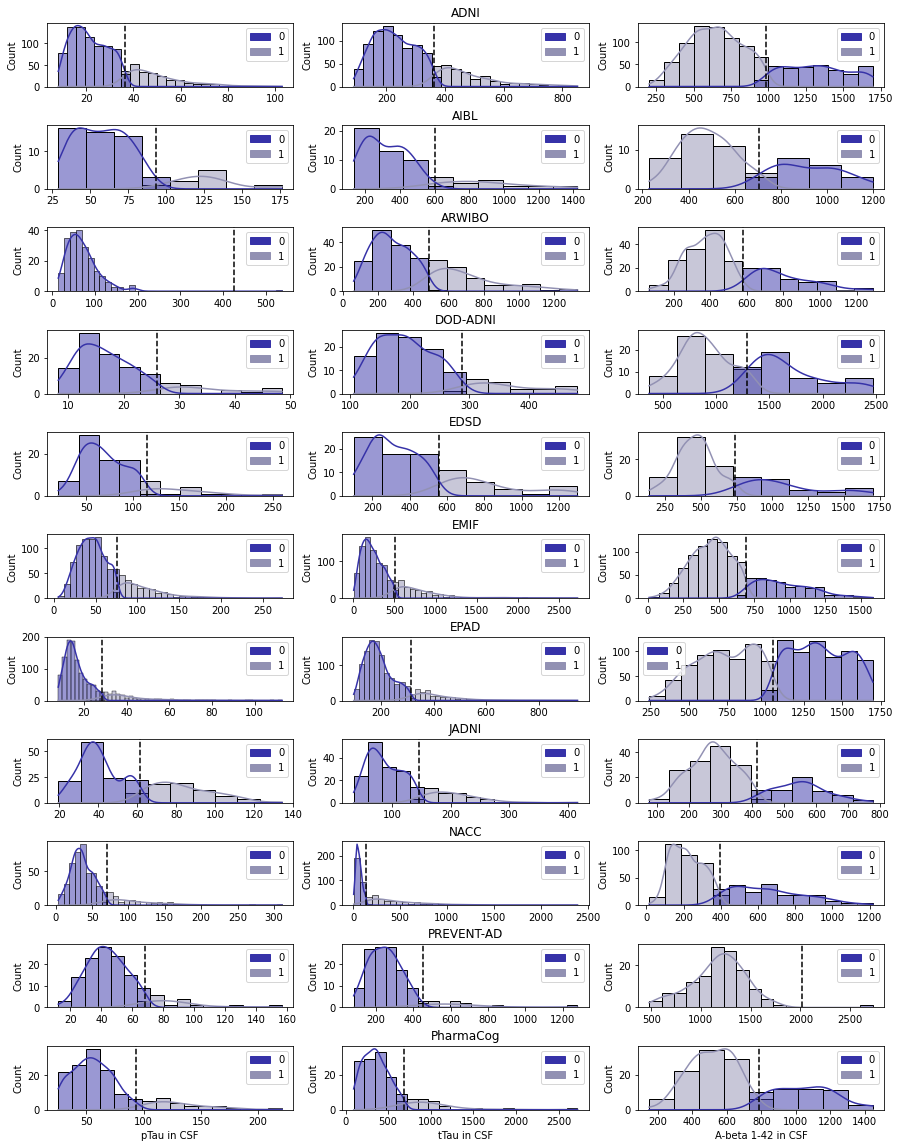

In [23]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(15, 20))
fig.subplots_adjust(hspace=0.6)
i=0

for ind in cutoffs_dfs['gmm_baseline_cutoffs'].index.to_list():
    csf = mappings['csf'].iloc[:3][ind].to_list()
    feat_ = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, fea_  in zip(csf, feat_):
        sns.histplot(x=cohort_studies[ind][bioma], ax=axes[i, csf.index(bioma)], kde=True, palette={0: '#3632a8', 1: '#9291b3'}, hue=cohort_studies[ind]["gmm_baseline_" + fea_.split()[0]])
        axes[i, csf.index(bioma)].axvline(x=cutoffs_dfs['gmm_baseline_cutoffs'].loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--')
        patch1 = mpatches.Patch(color='#3632a8', label='0')
        patch2 = mpatches.Patch(color='#9291b3', label='1')
        axes[i, csf.index(bioma)].legend(handles=[patch1, patch2], ncol=1)
        axes[i, csf.index(bioma)].set(xlabel='')
        axes[i, 1].set_title(ind, fontsize=12, pad=6)
        axes[10, csf.index(bioma)].set_xlabel(fea_, fontsize=10)
        
    i+=1
    
plt.savefig("../results/clusters_gmm_baseline.png", dpi=300, bbox_inches='tight')

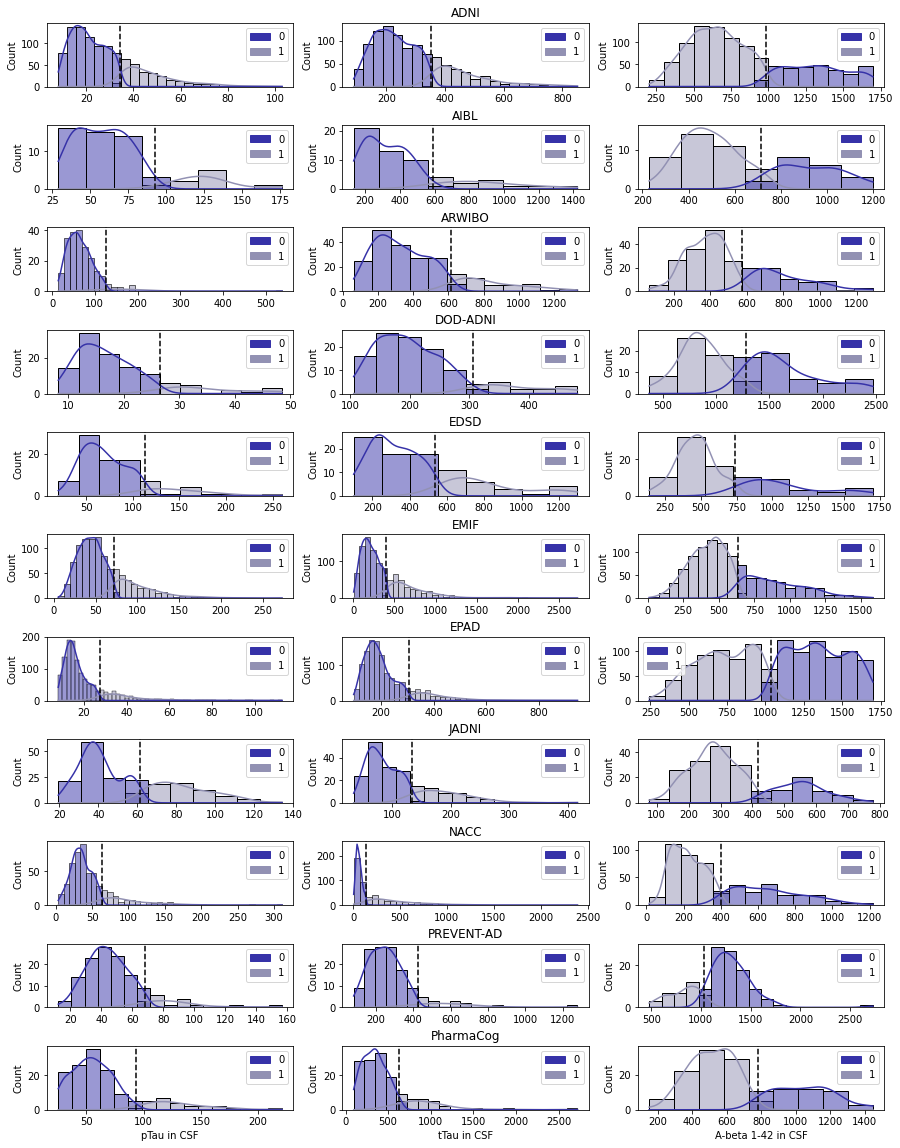

In [24]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(15, 20))
fig.subplots_adjust(hspace=0.6)
# fig.suptitle("TEST", fontsize=16)
i=0

for ind in cutoffs_dfs['gmm_cutoffs'].index.to_list():
    csf = mappings['csf'].iloc[:3][ind].to_list()
    feat_ = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, fea_  in zip(csf, feat_):
        sns.histplot(x=cohort_studies[ind][bioma], ax=axes[i, csf.index(bioma)], kde=True, palette={0: '#3632a8', 1: '#9291b3'}, hue=cohort_studies[ind]["gmm_" + fea_.split()[0]])
        axes[i, csf.index(bioma)].axvline(x=cutoffs_dfs['gmm_cutoffs'].loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 
        patch1 = mpatches.Patch(color='#3632a8', label='0')
        patch2 = mpatches.Patch(color='#9291b3', label='1')
        axes[i, csf.index(bioma)].legend(handles=[patch1, patch2], ncol=1)
        axes[i, csf.index(bioma)].set(xlabel='')
        axes[i, 1].set_title(ind, fontsize=12, pad=6)
        axes[10, csf.index(bioma)].set_xlabel(fea_, fontsize=10)
    
    i+=1
    
plt.savefig("../results/clusters_gmm.png", dpi=300, bbox_inches='tight')

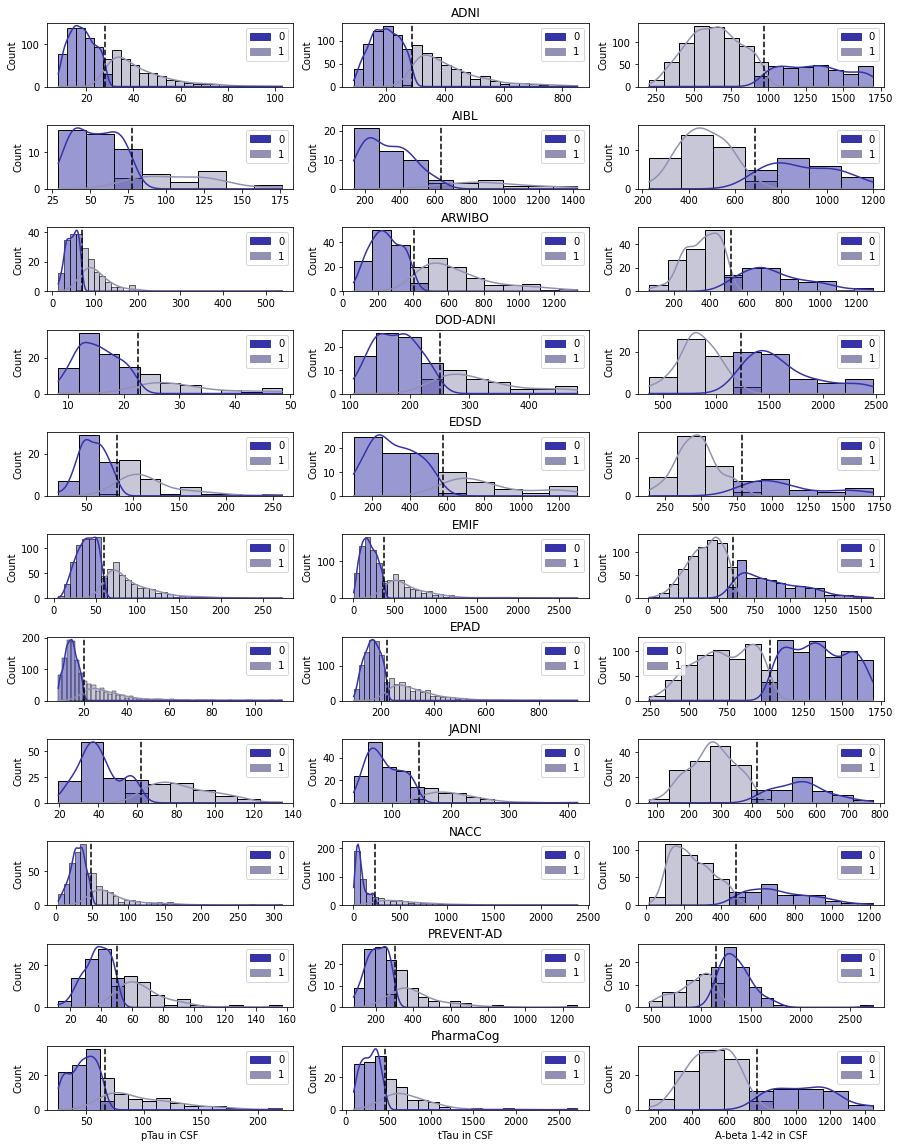

In [25]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(15, 20))
fig.subplots_adjust(hspace=0.6)
i=0

for ind in cutoffs_dfs['km_cutoffs'].index.to_list():
    csf = mappings['csf'].iloc[:3][ind].to_list()
    feat_ = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, fea_  in zip(csf, feat_):
        sns.histplot(x=cohort_studies[ind][bioma], ax=axes[i, csf.index(bioma)], kde=True, palette={0: '#3632a8', 1: '#9291b3'}, hue=cohort_studies[ind]["km_" + fea_.split()[0]])
        axes[i, csf.index(bioma)].axvline(x=cutoffs_dfs['km_cutoffs'].loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 
        patch1 = mpatches.Patch(color='#3632a8', label='0')
        patch2 = mpatches.Patch(color='#9291b3', label='1')
        axes[i, csf.index(bioma)].legend(handles=[patch1, patch2], ncol=1)
        axes[i, csf.index(bioma)].set(xlabel='')
        axes[i, 1].set_title(ind, fontsize=12, pad=6)
        axes[10, csf.index(bioma)].set_xlabel(fea_, fontsize=10)
    
    i+=1
    
plt.savefig("../results/clusters_km.png", dpi=300, bbox_inches='tight')

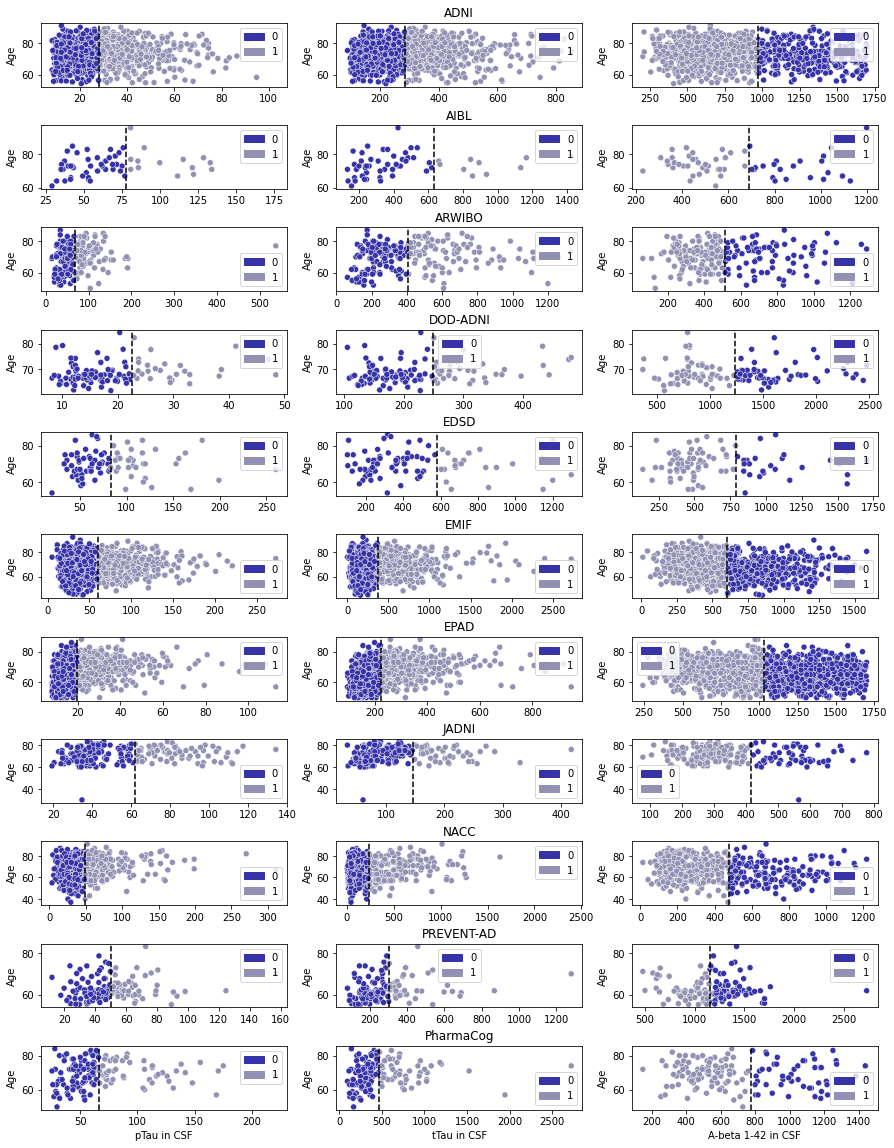

In [27]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(15, 20))
fig.subplots_adjust(hspace=0.6)
i=0

for ind in cutoffs_dfs['km_cutoffs'].index.to_list():
    csf = mappings['csf'].iloc[:3][ind].to_list()
    feat_ = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, fea_  in zip(csf, feat_):
        sns.scatterplot(x=cohort_studies[ind][bioma], y=cohort_studies[ind]['Age'], ax=axes[i, csf.index(bioma)], palette={0: '#3632a8', 1: '#9291b3'}, hue=cohort_studies[ind]["km_" + fea_.split()[0]])
        axes[i, csf.index(bioma)].axvline(x=cutoffs_dfs['km_cutoffs'].loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 
        patch1 = mpatches.Patch(color='#3632a8', label='0')
        patch2 = mpatches.Patch(color='#9291b3', label='1')
        axes[i, csf.index(bioma)].legend(handles=[patch1, patch2], ncol=1)
        axes[i, csf.index(bioma)].set(xlabel='')
        axes[i, 1].set_title(ind, fontsize=12, pad=6)
        axes[10, csf.index(bioma)].set_xlabel(fea_, fontsize=10)
    
    i+=1
    
# plt.savefig("../results/clusters_km.png", dpi=300, bbox_inches='tight')